# RNN implementation and testing

In [ ]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import random
import atari_py
import time
from tqdm import tqdm

# Tensorflow imports
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import losses
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

In [2]:
# Load the Atari ROM files
!python -m atari_py.import_roms ROMS/

copying keystone_kapers.bin from ROMS/Keystone Kapers - Raueber und Gendarm (1983) (Activision, Garry Kitchen - Ariola) (EAX-025, EAX-025-04I - 711 025-725) (PAL).bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/keystone_kapers.bin
copying up_n_down.bin from ROMS/Up 'n Down (1984) (SEGA - Beck-Tech, Steve Beck, Phat Ho) (009-01) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/up_n_down.bin
copying surround.bin from ROMS/Surround - Chase (Blockade) (1977) (Atari, Alan Miller - Sears) (CX2641 - 99807, 49-75105) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/surround.bin
copying pitfall.bin from ROMS/Pitfall! - Pitfall Harry's Jungle Adventure (Jungle Runner) (1982) (Activision, David Crane) (AX-018, AX-018-04) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/pitfall.bin
copying frogger.bin from ROMS/Frogger (1982) (Parker Brothers, E

copying crazy_climber.bin from ROMS/Crazy Climber (1983) (Atari - Roklan, Joe Gaucher, Alex Leavens) (CX2683) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/crazy_climber.bin
copying koolaid.bin from ROMS/Kool-Aid Man (Kool Aid Pitcher Man) (1983) (M Network, Stephen Tatsumi, Jane Terjung - Kool Aid) (MT4648) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/koolaid.bin
copying tennis.bin from ROMS/Tennis - Le Tennis (1981) (Activision, Alan Miller) (AG-007, CAG-007) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/tennis.bin
copying frostbite.bin from ROMS/Frostbite (1983) (Activision, Steve Cartwright) (AX-031) ~.bin to /home/djesse/anaconda3/envs/nc/lib/python3.8/site-packages/atari_py/atari_roms/frostbite.bin
copying time_pilot.bin from ROMS/Time Pilot (1983) (Coleco - Woodside Design Associates, Harley H. Puthuff Jr.) (2663) ~.bin to /home/djesse/anaconda3/envs/nc/

## Data collection

In [4]:
env = gym.make('MsPacman-ram-v0')

In [19]:
# Inspect
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [24]:
def collect_rnn_input(n_episodes, timesteps, allowed_actions, render=False):
    state_sequences = []
    action_sequences = []
    
    for i in tqdm(range(n_episodes)):
        
        env.reset()
        
        state_batch = []
        action_batch = []
        
        counter = 0
        
        for step in range(timesteps):
            
            # Sample a random action from the allowed action space
            action = np.random.choice(allowed_actions)
            state, reward, done, info = env.step(action)  
            
            # Only store dynamics if the agent starts moving (experimentally determined to 90)
            if counter >= 90:
                # Store state and action
                state_batch.append(state)
                action_batch.append(action)
            
            counter += 1
            
            if render:
                time.sleep(0.01)
                env.render()
            
            # If the episode ends before the specified number of steps is reached, reset
            if done:
                env.reset()
                counter = 0
        
        # Store episode dynamics
        state_sequences.append(np.array(state_batch))
        action_sequences.append(np.array(action_batch))
        
    env.close()
    
    return {
        'state': state_sequences,
        'action': action_sequences,
    }

# Change to [1, 2, 3, 4] to only allow UP, DOWN, LEFT, RIGHT
allowed_actions = list(range(9))
sequences = collect_rnn_input(n_episodes=400, timesteps=1000, allowed_actions=allowed_actions, render=False)

100%|██████████| 400/400 [02:37<00:00,  2.54it/s]


In [25]:
def get_training_data(sequences):
    
    states = []
    actions = []
    
    for i in range(len(sequences)):        
        states.append(sequences['state'][i])
        
        action = np.expand_dims(sequences['action'][i], axis=1)
        actions.append(action)
        
    return np.array(states), np.array(actions)

## RNN model definition

We based our implementation for the RNN on [this source](https://github.com/AppliedDataSciencePartners/WorldModels/blob/master/rnn/arch.py)

In [26]:
# Dimensionality of state vector
Z_DIM = 128

# Dimensionality of action vector
ACTION_DIM = 1

# Number of hidden units in the LSTM layer
HIDDEN_UNITS = 256
GAUSSIAN_MIXTURES = 1

LEARNING_RATE = 0.001


class RNN():
    def __init__(self): 

        self.z_dim = Z_DIM
        self.action_dim = ACTION_DIM
        self.hidden_units = HIDDEN_UNITS
        self.gaussian_mixtures = GAUSSIAN_MIXTURES
        self.learning_rate = LEARNING_RATE

        self.models = self._build()
        self.model = self.models[0]
        self.forward = self.models[1]


    def _build(self):

        #### THE MODEL THAT WILL BE TRAINED
        rnn_x = Input(shape=(None, Z_DIM + ACTION_DIM))
        lstm = LSTM(HIDDEN_UNITS, return_sequences=True, return_state = True)

        lstm_output_model, _ , _ = lstm(rnn_x)
        mdn = Dense(Z_DIM) 

        mdn_model = mdn(lstm_output_model)

        model = Model(rnn_x, mdn_model)

        #### THE MODEL USED DURING PREDICTION
        state_input_h = Input(shape=(HIDDEN_UNITS,))
        state_input_c = Input(shape=(HIDDEN_UNITS,))

        lstm_output_forward ,state_h, state_c = lstm(rnn_x, initial_state = [state_input_h, state_input_c])

        mdn_forward = mdn(lstm_output_forward)

        forward = Model([rnn_x] + [state_input_h, state_input_c], [mdn_forward, state_h, state_c])

        #### LOSS FUNCTION
        def rnn_z_loss(y_true, y_pred):
            loss = losses.mean_squared_error(y_true, y_pred)
            return K.mean(loss)     


        def rnn_loss(y_true, y_pred):
            z_loss = rnn_z_loss(y_true, y_pred)
            return z_loss

        opti = Adam(lr=LEARNING_RATE)
        model.compile(loss=rnn_loss, optimizer=opti, metrics = [rnn_z_loss])
    

        return (model,forward)

    def train(self, rnn_input, rnn_output, epochs, batch_size):

        history = self.model.fit(rnn_input, rnn_output,
            shuffle=False,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2)
        
        return history

## Training the RNN model

In [27]:
# Initialise the RNN model
rnn = RNN()

# Fetch the training data
states, actions = get_training_data(sequences)

# Construct the required input and output format
rnn_input = np.concatenate([states[:, :-1, :], actions[:, :-1, :]], axis=2)
rnn_output = np.concatenate([states[:, 1:, :]], axis=2)

# Train the RNN
history = rnn.train(rnn_input, rnn_output, epochs=4000, batch_size=128)

Epoch 1/4000
1/1 [==============================] - 2s 2s/step - loss: 21016.9629 - rnn_z_loss: 21016.9629 - val_loss: 21161.6172 - val_rnn_z_loss: 21161.6172
Epoch 2/4000
1/1 [==============================] - 0s 394ms/step - loss: 20964.9297 - rnn_z_loss: 20964.9297 - val_loss: 21118.8398 - val_rnn_z_loss: 21118.8398
Epoch 3/4000
1/1 [==============================] - 0s 401ms/step - loss: 20922.2168 - rnn_z_loss: 20922.2168 - val_loss: 21081.0625 - val_rnn_z_loss: 21081.0625
Epoch 4/4000
1/1 [==============================] - 0s 399ms/step - loss: 20882.8496 - rnn_z_loss: 20882.8496 - val_loss: 21051.9316 - val_rnn_z_loss: 21051.9316
Epoch 5/4000
1/1 [==============================] - 0s 388ms/step - loss: 20853.5781 - rnn_z_loss: 20853.5781 - val_loss: 21025.3164 - val_rnn_z_loss: 21025.3164
Epoch 6/4000
1/1 [==============================] - 0s 391ms/step - loss: 20827.6133 - rnn_z_loss: 20827.6133 - val_loss: 21001.1133 - val_rnn_z_loss: 21001.1133
Epoch 7/4000
1/1 [=============

1/1 [==============================] - 0s 459ms/step - loss: 18743.0430 - rnn_z_loss: 18743.0430 - val_loss: 18901.3594 - val_rnn_z_loss: 18901.3594
Epoch 102/4000
1/1 [==============================] - 0s 420ms/step - loss: 18722.1602 - rnn_z_loss: 18722.1602 - val_loss: 18880.3398 - val_rnn_z_loss: 18880.3398
Epoch 103/4000
1/1 [==============================] - 0s 432ms/step - loss: 18701.3086 - rnn_z_loss: 18701.3086 - val_loss: 18859.3496 - val_rnn_z_loss: 18859.3496
Epoch 104/4000
1/1 [==============================] - 0s 443ms/step - loss: 18680.4863 - rnn_z_loss: 18680.4863 - val_loss: 18838.3887 - val_rnn_z_loss: 18838.3887
Epoch 105/4000
1/1 [==============================] - 0s 429ms/step - loss: 18659.6992 - rnn_z_loss: 18659.6992 - val_loss: 18817.4609 - val_rnn_z_loss: 18817.4609
Epoch 106/4000
1/1 [==============================] - 0s 428ms/step - loss: 18638.9355 - rnn_z_loss: 18638.9355 - val_loss: 18796.5645 - val_rnn_z_loss: 18796.5645
Epoch 107/4000
1/1 [===========

1/1 [==============================] - 0s 479ms/step - loss: 17720.2480 - rnn_z_loss: 17720.2480 - val_loss: 17870.9980 - val_rnn_z_loss: 17870.9980
Epoch 152/4000
1/1 [==============================] - 0s 456ms/step - loss: 17700.1562 - rnn_z_loss: 17700.1562 - val_loss: 17850.7617 - val_rnn_z_loss: 17850.7617
Epoch 153/4000
1/1 [==============================] - 0s 458ms/step - loss: 17680.0859 - rnn_z_loss: 17680.0859 - val_loss: 17830.5469 - val_rnn_z_loss: 17830.5469
Epoch 154/4000
1/1 [==============================] - 0s 467ms/step - loss: 17660.0391 - rnn_z_loss: 17660.0391 - val_loss: 17810.3574 - val_rnn_z_loss: 17810.3574
Epoch 155/4000
1/1 [==============================] - 0s 470ms/step - loss: 17640.0117 - rnn_z_loss: 17640.0117 - val_loss: 17790.1914 - val_rnn_z_loss: 17790.1914
Epoch 156/4000
1/1 [==============================] - 0s 491ms/step - loss: 17620.0098 - rnn_z_loss: 17620.0098 - val_loss: 17770.0508 - val_rnn_z_loss: 17770.0508
Epoch 157/4000
1/1 [===========

1/1 [==============================] - 0s 449ms/step - loss: 16748.5742 - rnn_z_loss: 16748.5742 - val_loss: 16892.6738 - val_rnn_z_loss: 16892.6738
Epoch 202/4000
1/1 [==============================] - 1s 508ms/step - loss: 16729.8145 - rnn_z_loss: 16729.8145 - val_loss: 16873.7832 - val_rnn_z_loss: 16873.7832
Epoch 203/4000
1/1 [==============================] - 1s 522ms/step - loss: 16711.0801 - rnn_z_loss: 16711.0801 - val_loss: 16854.9199 - val_rnn_z_loss: 16854.9199
Epoch 204/4000
1/1 [==============================] - 1s 531ms/step - loss: 16692.3691 - rnn_z_loss: 16692.3691 - val_loss: 16836.0781 - val_rnn_z_loss: 16836.0781
Epoch 205/4000
1/1 [==============================] - 0s 451ms/step - loss: 16673.6816 - rnn_z_loss: 16673.6816 - val_loss: 16817.2617 - val_rnn_z_loss: 16817.2617
Epoch 206/4000
1/1 [==============================] - 1s 550ms/step - loss: 16655.0215 - rnn_z_loss: 16655.0215 - val_loss: 16798.4707 - val_rnn_z_loss: 16798.4707
Epoch 207/4000
1/1 [===========

1/1 [==============================] - 0s 418ms/step - loss: 15824.4932 - rnn_z_loss: 15824.4932 - val_loss: 15961.8184 - val_rnn_z_loss: 15961.8184
Epoch 252/4000
1/1 [==============================] - 0s 449ms/step - loss: 15806.3867 - rnn_z_loss: 15806.3867 - val_loss: 15943.5869 - val_rnn_z_loss: 15943.5869
Epoch 253/4000
1/1 [==============================] - 0s 490ms/step - loss: 15788.3066 - rnn_z_loss: 15788.3066 - val_loss: 15925.3848 - val_rnn_z_loss: 15925.3848
Epoch 254/4000
1/1 [==============================] - 0s 448ms/step - loss: 15770.2549 - rnn_z_loss: 15770.2549 - val_loss: 15907.2080 - val_rnn_z_loss: 15907.2080
Epoch 255/4000
1/1 [==============================] - 0s 463ms/step - loss: 15752.2275 - rnn_z_loss: 15752.2275 - val_loss: 15889.0596 - val_rnn_z_loss: 15889.0596
Epoch 256/4000
1/1 [==============================] - 0s 459ms/step - loss: 15734.2285 - rnn_z_loss: 15734.2285 - val_loss: 15870.9385 - val_rnn_z_loss: 15870.9385
Epoch 257/4000
1/1 [===========

1/1 [==============================] - 1s 501ms/step - loss: 14949.5811 - rnn_z_loss: 14949.5811 - val_loss: 15080.8740 - val_rnn_z_loss: 15080.8740
Epoch 302/4000
1/1 [==============================] - 0s 475ms/step - loss: 14932.6641 - rnn_z_loss: 14932.6641 - val_loss: 15063.8398 - val_rnn_z_loss: 15063.8398
Epoch 303/4000
1/1 [==============================] - 0s 490ms/step - loss: 14915.7705 - rnn_z_loss: 14915.7705 - val_loss: 15046.8262 - val_rnn_z_loss: 15046.8262
Epoch 304/4000
1/1 [==============================] - 0s 468ms/step - loss: 14898.8975 - rnn_z_loss: 14898.8975 - val_loss: 15029.8350 - val_rnn_z_loss: 15029.8350
Epoch 305/4000
1/1 [==============================] - 0s 439ms/step - loss: 14882.0449 - rnn_z_loss: 14882.0449 - val_loss: 15012.8672 - val_rnn_z_loss: 15012.8672
Epoch 306/4000
1/1 [==============================] - 0s 432ms/step - loss: 14865.2129 - rnn_z_loss: 14865.2129 - val_loss: 14995.9170 - val_rnn_z_loss: 14995.9170
Epoch 307/4000
1/1 [===========

1/1 [==============================] - 0s 422ms/step - loss: 14128.6357 - rnn_z_loss: 14128.6357 - val_loss: 14254.1768 - val_rnn_z_loss: 14254.1768
Epoch 352/4000
1/1 [==============================] - 0s 403ms/step - loss: 14112.7158 - rnn_z_loss: 14112.7158 - val_loss: 14238.1426 - val_rnn_z_loss: 14238.1426
Epoch 353/4000
1/1 [==============================] - 0s 413ms/step - loss: 14096.8115 - rnn_z_loss: 14096.8115 - val_loss: 14222.1270 - val_rnn_z_loss: 14222.1270
Epoch 354/4000
1/1 [==============================] - 0s 414ms/step - loss: 14080.9268 - rnn_z_loss: 14080.9268 - val_loss: 14206.1309 - val_rnn_z_loss: 14206.1309
Epoch 355/4000
1/1 [==============================] - 0s 416ms/step - loss: 14065.0615 - rnn_z_loss: 14065.0615 - val_loss: 14190.1514 - val_rnn_z_loss: 14190.1514
Epoch 356/4000
1/1 [==============================] - 0s 433ms/step - loss: 14049.2129 - rnn_z_loss: 14049.2129 - val_loss: 14174.1943 - val_rnn_z_loss: 14174.1943
Epoch 357/4000
1/1 [===========

1/1 [==============================] - 0s 428ms/step - loss: 13354.8428 - rnn_z_loss: 13354.8428 - val_loss: 13474.9463 - val_rnn_z_loss: 13474.9463
Epoch 402/4000
1/1 [==============================] - 0s 404ms/step - loss: 13339.8193 - rnn_z_loss: 13339.8193 - val_loss: 13459.8184 - val_rnn_z_loss: 13459.8184
Epoch 403/4000
1/1 [==============================] - 0s 408ms/step - loss: 13324.8105 - rnn_z_loss: 13324.8105 - val_loss: 13444.7031 - val_rnn_z_loss: 13444.7031
Epoch 404/4000
1/1 [==============================] - 0s 434ms/step - loss: 13309.8203 - rnn_z_loss: 13309.8203 - val_loss: 13429.6104 - val_rnn_z_loss: 13429.6104
Epoch 405/4000
1/1 [==============================] - 0s 431ms/step - loss: 13294.8486 - rnn_z_loss: 13294.8486 - val_loss: 13414.5312 - val_rnn_z_loss: 13414.5312
Epoch 406/4000
1/1 [==============================] - 0s 419ms/step - loss: 13279.8936 - rnn_z_loss: 13279.8936 - val_loss: 13399.4697 - val_rnn_z_loss: 13399.4697
Epoch 407/4000
1/1 [===========

1/1 [==============================] - 0s 446ms/step - loss: 12608.2939 - rnn_z_loss: 12608.2939 - val_loss: 12723.1025 - val_rnn_z_loss: 12723.1025
Epoch 452/4000
1/1 [==============================] - 0s 440ms/step - loss: 12594.0547 - rnn_z_loss: 12594.0547 - val_loss: 12708.7646 - val_rnn_z_loss: 12708.7646
Epoch 453/4000
1/1 [==============================] - 0s 473ms/step - loss: 12579.8311 - rnn_z_loss: 12579.8311 - val_loss: 12694.4395 - val_rnn_z_loss: 12694.4395
Epoch 454/4000
1/1 [==============================] - 0s 468ms/step - loss: 12565.6250 - rnn_z_loss: 12565.6250 - val_loss: 12680.1348 - val_rnn_z_loss: 12680.1348
Epoch 455/4000
1/1 [==============================] - 0s 450ms/step - loss: 12551.4336 - rnn_z_loss: 12551.4336 - val_loss: 12665.8457 - val_rnn_z_loss: 12665.8457
Epoch 456/4000
1/1 [==============================] - 0s 440ms/step - loss: 12537.2578 - rnn_z_loss: 12537.2578 - val_loss: 12651.5723 - val_rnn_z_loss: 12651.5723
Epoch 457/4000
1/1 [===========

1/1 [==============================] - 1s 570ms/step - loss: 11915.6973 - rnn_z_loss: 11915.6973 - val_loss: 12025.7109 - val_rnn_z_loss: 12025.7109
Epoch 502/4000
1/1 [==============================] - 1s 553ms/step - loss: 11902.2422 - rnn_z_loss: 11902.2422 - val_loss: 12012.1621 - val_rnn_z_loss: 12012.1621
Epoch 503/4000
1/1 [==============================] - 0s 485ms/step - loss: 11888.7998 - rnn_z_loss: 11888.7998 - val_loss: 11998.6260 - val_rnn_z_loss: 11998.6260
Epoch 504/4000
1/1 [==============================] - 1s 508ms/step - loss: 11875.3740 - rnn_z_loss: 11875.3740 - val_loss: 11985.1084 - val_rnn_z_loss: 11985.1084
Epoch 505/4000
1/1 [==============================] - 1s 506ms/step - loss: 11861.9619 - rnn_z_loss: 11861.9619 - val_loss: 11971.6045 - val_rnn_z_loss: 11971.6045
Epoch 506/4000
1/1 [==============================] - 0s 458ms/step - loss: 11848.5654 - rnn_z_loss: 11848.5654 - val_loss: 11958.1182 - val_rnn_z_loss: 11958.1182
Epoch 507/4000
1/1 [===========

1/1 [==============================] - 0s 421ms/step - loss: 11261.0479 - rnn_z_loss: 11261.0479 - val_loss: 11366.5762 - val_rnn_z_loss: 11366.5762
Epoch 552/4000
1/1 [==============================] - 0s 408ms/step - loss: 11248.3232 - rnn_z_loss: 11248.3232 - val_loss: 11353.7676 - val_rnn_z_loss: 11353.7676
Epoch 553/4000
1/1 [==============================] - 0s 423ms/step - loss: 11235.6143 - rnn_z_loss: 11235.6143 - val_loss: 11340.9727 - val_rnn_z_loss: 11340.9727
Epoch 554/4000
1/1 [==============================] - 0s 409ms/step - loss: 11222.9219 - rnn_z_loss: 11222.9219 - val_loss: 11328.1914 - val_rnn_z_loss: 11328.1914
Epoch 555/4000
1/1 [==============================] - 0s 404ms/step - loss: 11210.2422 - rnn_z_loss: 11210.2422 - val_loss: 11315.4248 - val_rnn_z_loss: 11315.4248
Epoch 556/4000
1/1 [==============================] - 0s 435ms/step - loss: 11197.5752 - rnn_z_loss: 11197.5752 - val_loss: 11302.6738 - val_rnn_z_loss: 11302.6738
Epoch 557/4000
1/1 [===========

1/1 [==============================] - 1s 538ms/step - loss: 10641.9756 - rnn_z_loss: 10641.9756 - val_loss: 10743.3232 - val_rnn_z_loss: 10743.3232
Epoch 602/4000
1/1 [==============================] - 0s 444ms/step - loss: 10629.9424 - rnn_z_loss: 10629.9424 - val_loss: 10731.2100 - val_rnn_z_loss: 10731.2100
Epoch 603/4000
1/1 [==============================] - 0s 487ms/step - loss: 10617.9229 - rnn_z_loss: 10617.9229 - val_loss: 10719.1084 - val_rnn_z_loss: 10719.1084
Epoch 604/4000
1/1 [==============================] - 0s 473ms/step - loss: 10605.9160 - rnn_z_loss: 10605.9160 - val_loss: 10707.0205 - val_rnn_z_loss: 10707.0205
Epoch 605/4000
1/1 [==============================] - 0s 455ms/step - loss: 10593.9219 - rnn_z_loss: 10593.9219 - val_loss: 10694.9463 - val_rnn_z_loss: 10694.9463
Epoch 606/4000
1/1 [==============================] - 0s 457ms/step - loss: 10581.9414 - rnn_z_loss: 10581.9414 - val_loss: 10682.8867 - val_rnn_z_loss: 10682.8867
Epoch 607/4000
1/1 [===========

1/1 [==============================] - 1s 560ms/step - loss: 10056.3408 - rnn_z_loss: 10056.3408 - val_loss: 10153.7959 - val_rnn_z_loss: 10153.7959
Epoch 652/4000
1/1 [==============================] - 1s 570ms/step - loss: 10044.9570 - rnn_z_loss: 10044.9570 - val_loss: 10142.3359 - val_rnn_z_loss: 10142.3359
Epoch 653/4000
1/1 [==============================] - 1s 582ms/step - loss: 10033.5830 - rnn_z_loss: 10033.5830 - val_loss: 10130.8887 - val_rnn_z_loss: 10130.8887
Epoch 654/4000
1/1 [==============================] - 0s 450ms/step - loss: 10022.2227 - rnn_z_loss: 10022.2227 - val_loss: 10119.4531 - val_rnn_z_loss: 10119.4531
Epoch 655/4000
1/1 [==============================] - 0s 425ms/step - loss: 10010.8750 - rnn_z_loss: 10010.8750 - val_loss: 10108.0312 - val_rnn_z_loss: 10108.0312
Epoch 656/4000
1/1 [==============================] - 0s 423ms/step - loss: 9999.5400 - rnn_z_loss: 9999.5400 - val_loss: 10096.6211 - val_rnn_z_loss: 10096.6211
Epoch 657/4000
1/1 [=============

1/1 [==============================] - 0s 469ms/step - loss: 9491.4131 - rnn_z_loss: 9491.4131 - val_loss: 9585.1797 - val_rnn_z_loss: 9585.1797
Epoch 703/4000
1/1 [==============================] - 0s 451ms/step - loss: 9480.6494 - rnn_z_loss: 9480.6494 - val_loss: 9574.3477 - val_rnn_z_loss: 9574.3477
Epoch 704/4000
1/1 [==============================] - 0s 472ms/step - loss: 9469.8994 - rnn_z_loss: 9469.8994 - val_loss: 9563.5273 - val_rnn_z_loss: 9563.5273
Epoch 705/4000
1/1 [==============================] - 1s 507ms/step - loss: 9459.1602 - rnn_z_loss: 9459.1602 - val_loss: 9552.7178 - val_rnn_z_loss: 9552.7178
Epoch 706/4000
1/1 [==============================] - 1s 598ms/step - loss: 9448.4326 - rnn_z_loss: 9448.4326 - val_loss: 9541.9219 - val_rnn_z_loss: 9541.9219
Epoch 707/4000
1/1 [==============================] - 1s 588ms/step - loss: 9437.7178 - rnn_z_loss: 9437.7178 - val_loss: 9531.1377 - val_rnn_z_loss: 9531.1377
Epoch 708/4000
1/1 [==============================] - 1

1/1 [==============================] - 0s 481ms/step - loss: 8452.3232 - rnn_z_loss: 8452.3232 - val_loss: 8539.5000 - val_rnn_z_loss: 8539.5000
Epoch 805/4000
1/1 [==============================] - 1s 562ms/step - loss: 8442.7002 - rnn_z_loss: 8442.7002 - val_loss: 8529.8184 - val_rnn_z_loss: 8529.8184
Epoch 806/4000
1/1 [==============================] - 1s 600ms/step - loss: 8433.0889 - rnn_z_loss: 8433.0889 - val_loss: 8520.1455 - val_rnn_z_loss: 8520.1455
Epoch 807/4000
1/1 [==============================] - 1s 615ms/step - loss: 8423.4873 - rnn_z_loss: 8423.4873 - val_loss: 8510.4854 - val_rnn_z_loss: 8510.4854
Epoch 808/4000
1/1 [==============================] - 1s 524ms/step - loss: 8413.8965 - rnn_z_loss: 8413.8965 - val_loss: 8500.8350 - val_rnn_z_loss: 8500.8350
Epoch 809/4000
1/1 [==============================] - 1s 554ms/step - loss: 8404.3164 - rnn_z_loss: 8404.3164 - val_loss: 8491.1943 - val_rnn_z_loss: 8491.1943
Epoch 810/4000
1/1 [==============================] - 1

1/1 [==============================] - 0s 402ms/step - loss: 7523.1479 - rnn_z_loss: 7523.1479 - val_loss: 7604.6533 - val_rnn_z_loss: 7604.6533
Epoch 907/4000
1/1 [==============================] - 0s 407ms/step - loss: 7514.5405 - rnn_z_loss: 7514.5405 - val_loss: 7595.9951 - val_rnn_z_loss: 7595.9951
Epoch 908/4000
1/1 [==============================] - 0s 400ms/step - loss: 7505.9443 - rnn_z_loss: 7505.9443 - val_loss: 7587.3481 - val_rnn_z_loss: 7587.3481
Epoch 909/4000
1/1 [==============================] - 1s 506ms/step - loss: 7497.3584 - rnn_z_loss: 7497.3584 - val_loss: 7578.7095 - val_rnn_z_loss: 7578.7095
Epoch 910/4000
1/1 [==============================] - 0s 439ms/step - loss: 7488.7808 - rnn_z_loss: 7488.7808 - val_loss: 7570.0801 - val_rnn_z_loss: 7570.0801
Epoch 911/4000
1/1 [==============================] - 0s 421ms/step - loss: 7480.2114 - rnn_z_loss: 7480.2114 - val_loss: 7561.4614 - val_rnn_z_loss: 7561.4614
Epoch 912/4000
1/1 [==============================] - 0

1/1 [==============================] - 0s 423ms/step - loss: 6692.1748 - rnn_z_loss: 6692.1748 - val_loss: 6768.7759 - val_rnn_z_loss: 6768.7759
Epoch 1009/4000
1/1 [==============================] - 0s 421ms/step - loss: 6684.4785 - rnn_z_loss: 6684.4785 - val_loss: 6761.0361 - val_rnn_z_loss: 6761.0361
Epoch 1010/4000
1/1 [==============================] - 0s 420ms/step - loss: 6676.7930 - rnn_z_loss: 6676.7930 - val_loss: 6753.3042 - val_rnn_z_loss: 6753.3042
Epoch 1011/4000
1/1 [==============================] - 0s 441ms/step - loss: 6669.1138 - rnn_z_loss: 6669.1138 - val_loss: 6745.5806 - val_rnn_z_loss: 6745.5806
Epoch 1012/4000
1/1 [==============================] - 0s 445ms/step - loss: 6661.4443 - rnn_z_loss: 6661.4443 - val_loss: 6737.8662 - val_rnn_z_loss: 6737.8662
Epoch 1013/4000
1/1 [==============================] - 0s 417ms/step - loss: 6653.7822 - rnn_z_loss: 6653.7822 - val_loss: 6730.1592 - val_rnn_z_loss: 6730.1592
Epoch 1014/4000
1/1 [=============================

Epoch 1059/4000
1/1 [==============================] - 0s 434ms/step - loss: 6310.2979 - rnn_z_loss: 6310.2979 - val_loss: 6384.6880 - val_rnn_z_loss: 6384.6880
Epoch 1060/4000
1/1 [==============================] - 0s 427ms/step - loss: 6303.0225 - rnn_z_loss: 6303.0225 - val_loss: 6377.3706 - val_rnn_z_loss: 6377.3706
Epoch 1061/4000
1/1 [==============================] - 0s 429ms/step - loss: 6295.7539 - rnn_z_loss: 6295.7539 - val_loss: 6370.0615 - val_rnn_z_loss: 6370.0615
Epoch 1062/4000
1/1 [==============================] - 0s 423ms/step - loss: 6288.4946 - rnn_z_loss: 6288.4946 - val_loss: 6362.7593 - val_rnn_z_loss: 6362.7593
Epoch 1063/4000
1/1 [==============================] - 0s 421ms/step - loss: 6281.2432 - rnn_z_loss: 6281.2432 - val_loss: 6355.4663 - val_rnn_z_loss: 6355.4663
Epoch 1064/4000
1/1 [==============================] - 0s 407ms/step - loss: 6273.9995 - rnn_z_loss: 6273.9995 - val_loss: 6348.1807 - val_rnn_z_loss: 6348.1807
Epoch 1065/4000
1/1 [=============

Epoch 1110/4000
1/1 [==============================] - 0s 426ms/step - loss: 5949.2852 - rnn_z_loss: 5949.2852 - val_loss: 6021.6055 - val_rnn_z_loss: 6021.6055
Epoch 1111/4000
1/1 [==============================] - 0s 407ms/step - loss: 5942.4082 - rnn_z_loss: 5942.4082 - val_loss: 6014.6899 - val_rnn_z_loss: 6014.6899
Epoch 1112/4000
1/1 [==============================] - 0s 440ms/step - loss: 5935.5386 - rnn_z_loss: 5935.5386 - val_loss: 6007.7798 - val_rnn_z_loss: 6007.7798
Epoch 1113/4000
1/1 [==============================] - 0s 441ms/step - loss: 5928.6758 - rnn_z_loss: 5928.6758 - val_loss: 6000.8784 - val_rnn_z_loss: 6000.8784
Epoch 1114/4000
1/1 [==============================] - 0s 451ms/step - loss: 5921.8218 - rnn_z_loss: 5921.8218 - val_loss: 5993.9839 - val_rnn_z_loss: 5993.9839
Epoch 1115/4000
1/1 [==============================] - 0s 431ms/step - loss: 5914.9736 - rnn_z_loss: 5914.9736 - val_loss: 5987.0991 - val_rnn_z_loss: 5987.0991
Epoch 1116/4000
1/1 [=============

Epoch 1161/4000
1/1 [==============================] - 0s 420ms/step - loss: 5608.0786 - rnn_z_loss: 5608.0786 - val_loss: 5678.4556 - val_rnn_z_loss: 5678.4556
Epoch 1162/4000
1/1 [==============================] - 0s 419ms/step - loss: 5601.5806 - rnn_z_loss: 5601.5806 - val_loss: 5671.9189 - val_rnn_z_loss: 5671.9189
Epoch 1163/4000
1/1 [==============================] - 0s 413ms/step - loss: 5595.0879 - rnn_z_loss: 5595.0879 - val_loss: 5665.3901 - val_rnn_z_loss: 5665.3901
Epoch 1164/4000
1/1 [==============================] - 0s 409ms/step - loss: 5588.6040 - rnn_z_loss: 5588.6040 - val_loss: 5658.8687 - val_rnn_z_loss: 5658.8687
Epoch 1165/4000
1/1 [==============================] - 0s 413ms/step - loss: 5582.1260 - rnn_z_loss: 5582.1260 - val_loss: 5652.3545 - val_rnn_z_loss: 5652.3545
Epoch 1166/4000
1/1 [==============================] - 0s 408ms/step - loss: 5575.6558 - rnn_z_loss: 5575.6558 - val_loss: 5645.8481 - val_rnn_z_loss: 5645.8481
Epoch 1167/4000
1/1 [=============

Epoch 1212/4000
1/1 [==============================] - 0s 396ms/step - loss: 5285.6909 - rnn_z_loss: 5285.6909 - val_loss: 5354.2344 - val_rnn_z_loss: 5354.2344
Epoch 1213/4000
1/1 [==============================] - 0s 406ms/step - loss: 5279.5513 - rnn_z_loss: 5279.5513 - val_loss: 5348.0601 - val_rnn_z_loss: 5348.0601
Epoch 1214/4000
1/1 [==============================] - 0s 410ms/step - loss: 5273.4180 - rnn_z_loss: 5273.4180 - val_loss: 5341.8911 - val_rnn_z_loss: 5341.8911
Epoch 1215/4000
1/1 [==============================] - 0s 426ms/step - loss: 5267.2925 - rnn_z_loss: 5267.2925 - val_loss: 5335.7319 - val_rnn_z_loss: 5335.7319
Epoch 1216/4000
1/1 [==============================] - 0s 409ms/step - loss: 5261.1733 - rnn_z_loss: 5261.1733 - val_loss: 5329.5781 - val_rnn_z_loss: 5329.5781
Epoch 1217/4000
1/1 [==============================] - 0s 397ms/step - loss: 5255.0610 - rnn_z_loss: 5255.0610 - val_loss: 5323.4312 - val_rnn_z_loss: 5323.4312
Epoch 1218/4000
1/1 [=============

Epoch 1263/4000
1/1 [==============================] - 0s 404ms/step - loss: 4981.1919 - rnn_z_loss: 4981.1919 - val_loss: 5048.0049 - val_rnn_z_loss: 5048.0049
Epoch 1264/4000
1/1 [==============================] - 0s 414ms/step - loss: 4975.3940 - rnn_z_loss: 4975.3940 - val_loss: 5042.1748 - val_rnn_z_loss: 5042.1748
Epoch 1265/4000
1/1 [==============================] - 0s 430ms/step - loss: 4969.6030 - rnn_z_loss: 4969.6030 - val_loss: 5036.3506 - val_rnn_z_loss: 5036.3506
Epoch 1266/4000
1/1 [==============================] - 0s 412ms/step - loss: 4963.8188 - rnn_z_loss: 4963.8188 - val_loss: 5030.5337 - val_rnn_z_loss: 5030.5337
Epoch 1267/4000
1/1 [==============================] - 0s 412ms/step - loss: 4958.0410 - rnn_z_loss: 4958.0410 - val_loss: 5024.7227 - val_rnn_z_loss: 5024.7227
Epoch 1268/4000
1/1 [==============================] - 0s 412ms/step - loss: 4952.2690 - rnn_z_loss: 4952.2690 - val_loss: 5018.9175 - val_rnn_z_loss: 5018.9175
Epoch 1269/4000
1/1 [=============

Epoch 1314/4000
1/1 [==============================] - 0s 409ms/step - loss: 4693.7144 - rnn_z_loss: 4693.7144 - val_loss: 4758.8892 - val_rnn_z_loss: 4758.8892
Epoch 1315/4000
1/1 [==============================] - 0s 425ms/step - loss: 4688.2427 - rnn_z_loss: 4688.2427 - val_loss: 4753.3857 - val_rnn_z_loss: 4753.3857
Epoch 1316/4000
1/1 [==============================] - 0s 429ms/step - loss: 4682.7764 - rnn_z_loss: 4682.7764 - val_loss: 4747.8882 - val_rnn_z_loss: 4747.8882
Epoch 1317/4000
1/1 [==============================] - 0s 394ms/step - loss: 4677.3169 - rnn_z_loss: 4677.3169 - val_loss: 4742.3970 - val_rnn_z_loss: 4742.3970
Epoch 1318/4000
1/1 [==============================] - 0s 406ms/step - loss: 4671.8628 - rnn_z_loss: 4671.8628 - val_loss: 4736.9126 - val_rnn_z_loss: 4736.9126
Epoch 1319/4000
1/1 [==============================] - 0s 400ms/step - loss: 4666.4155 - rnn_z_loss: 4666.4155 - val_loss: 4731.4341 - val_rnn_z_loss: 4731.4341
Epoch 1320/4000
1/1 [=============

Epoch 1365/4000
1/1 [==============================] - 0s 424ms/step - loss: 4422.4409 - rnn_z_loss: 4422.4409 - val_loss: 4481.7886 - val_rnn_z_loss: 4481.7886
Epoch 1366/4000
1/1 [==============================] - 0s 435ms/step - loss: 4415.3135 - rnn_z_loss: 4415.3135 - val_loss: 4460.7378 - val_rnn_z_loss: 4460.7378
Epoch 1367/4000
1/1 [==============================] - 0s 434ms/step - loss: 4392.4121 - rnn_z_loss: 4392.4121 - val_loss: 4455.3071 - val_rnn_z_loss: 4455.3071
Epoch 1368/4000
1/1 [==============================] - 0s 432ms/step - loss: 4386.9443 - rnn_z_loss: 4386.9443 - val_loss: 4450.1313 - val_rnn_z_loss: 4450.1313
Epoch 1369/4000
1/1 [==============================] - 0s 406ms/step - loss: 4381.8042 - rnn_z_loss: 4381.8042 - val_loss: 4444.9629 - val_rnn_z_loss: 4444.9629
Epoch 1370/4000
1/1 [==============================] - 0s 404ms/step - loss: 4376.6714 - rnn_z_loss: 4376.6714 - val_loss: 4439.7998 - val_rnn_z_loss: 4439.7998
Epoch 1371/4000
1/1 [=============

Epoch 1416/4000
1/1 [==============================] - 0s 403ms/step - loss: 4146.8613 - rnn_z_loss: 4146.8613 - val_loss: 4208.7002 - val_rnn_z_loss: 4208.7002
Epoch 1417/4000
1/1 [==============================] - 0s 423ms/step - loss: 4142.0005 - rnn_z_loss: 4142.0005 - val_loss: 4203.8125 - val_rnn_z_loss: 4203.8125
Epoch 1418/4000
1/1 [==============================] - 0s 427ms/step - loss: 4137.1460 - rnn_z_loss: 4137.1460 - val_loss: 4198.9302 - val_rnn_z_loss: 4198.9302
Epoch 1419/4000
1/1 [==============================] - 0s 407ms/step - loss: 4132.2969 - rnn_z_loss: 4132.2969 - val_loss: 4194.0542 - val_rnn_z_loss: 4194.0542
Epoch 1420/4000
1/1 [==============================] - 0s 421ms/step - loss: 4127.4531 - rnn_z_loss: 4127.4531 - val_loss: 4189.1831 - val_rnn_z_loss: 4189.1831
Epoch 1421/4000
1/1 [==============================] - 0s 422ms/step - loss: 4122.6157 - rnn_z_loss: 4122.6157 - val_loss: 4184.3179 - val_rnn_z_loss: 4184.3179
Epoch 1422/4000
1/1 [=============

Epoch 1467/4000
1/1 [==============================] - 0s 430ms/step - loss: 3906.0913 - rnn_z_loss: 3906.0913 - val_loss: 3966.5564 - val_rnn_z_loss: 3966.5564
Epoch 1468/4000
1/1 [==============================] - 0s 395ms/step - loss: 3901.5129 - rnn_z_loss: 3901.5129 - val_loss: 3961.9521 - val_rnn_z_loss: 3961.9521
Epoch 1469/4000
1/1 [==============================] - 0s 436ms/step - loss: 3896.9404 - rnn_z_loss: 3896.9404 - val_loss: 3957.3525 - val_rnn_z_loss: 3957.3525
Epoch 1470/4000
1/1 [==============================] - 0s 427ms/step - loss: 3892.3723 - rnn_z_loss: 3892.3723 - val_loss: 3952.7593 - val_rnn_z_loss: 3952.7593
Epoch 1471/4000
1/1 [==============================] - 0s 399ms/step - loss: 3887.8108 - rnn_z_loss: 3887.8108 - val_loss: 3948.1707 - val_rnn_z_loss: 3948.1707
Epoch 1472/4000
1/1 [==============================] - 0s 404ms/step - loss: 3883.2537 - rnn_z_loss: 3883.2537 - val_loss: 3943.5879 - val_rnn_z_loss: 3943.5879
Epoch 1473/4000
1/1 [=============

Epoch 1518/4000
1/1 [==============================] - 0s 422ms/step - loss: 3679.3794 - rnn_z_loss: 3679.3794 - val_loss: 3738.5247 - val_rnn_z_loss: 3738.5247
Epoch 1519/4000
1/1 [==============================] - 0s 422ms/step - loss: 3675.0703 - rnn_z_loss: 3675.0703 - val_loss: 3734.1895 - val_rnn_z_loss: 3734.1895
Epoch 1520/4000
1/1 [==============================] - 0s 412ms/step - loss: 3670.7659 - rnn_z_loss: 3670.7659 - val_loss: 3729.8601 - val_rnn_z_loss: 3729.8601
Epoch 1521/4000
1/1 [==============================] - 0s 403ms/step - loss: 3666.4673 - rnn_z_loss: 3666.4673 - val_loss: 3725.5352 - val_rnn_z_loss: 3725.5352
Epoch 1522/4000
1/1 [==============================] - 0s 430ms/step - loss: 3662.1724 - rnn_z_loss: 3662.1724 - val_loss: 3721.2163 - val_rnn_z_loss: 3721.2163
Epoch 1523/4000
1/1 [==============================] - 0s 428ms/step - loss: 3657.8840 - rnn_z_loss: 3657.8840 - val_loss: 3716.9023 - val_rnn_z_loss: 3716.9023
Epoch 1524/4000
1/1 [=============

Epoch 1569/4000
1/1 [==============================] - 0s 425ms/step - loss: 3466.0601 - rnn_z_loss: 3466.0601 - val_loss: 3523.9363 - val_rnn_z_loss: 3523.9363
Epoch 1570/4000
1/1 [==============================] - 0s 420ms/step - loss: 3462.0068 - rnn_z_loss: 3462.0068 - val_loss: 3519.8589 - val_rnn_z_loss: 3519.8589
Epoch 1571/4000
1/1 [==============================] - 0s 419ms/step - loss: 3457.9587 - rnn_z_loss: 3457.9587 - val_loss: 3515.7861 - val_rnn_z_loss: 3515.7861
Epoch 1572/4000
1/1 [==============================] - 0s 439ms/step - loss: 3453.9155 - rnn_z_loss: 3453.9155 - val_loss: 3511.7185 - val_rnn_z_loss: 3511.7185
Epoch 1573/4000
1/1 [==============================] - 0s 433ms/step - loss: 3449.8770 - rnn_z_loss: 3449.8770 - val_loss: 3507.6560 - val_rnn_z_loss: 3507.6560
Epoch 1574/4000
1/1 [==============================] - 0s 416ms/step - loss: 3445.8430 - rnn_z_loss: 3445.8430 - val_loss: 3503.5984 - val_rnn_z_loss: 3503.5984
Epoch 1575/4000
1/1 [=============

Epoch 1620/4000
1/1 [==============================] - 0s 419ms/step - loss: 3265.4993 - rnn_z_loss: 3265.4993 - val_loss: 3322.1570 - val_rnn_z_loss: 3322.1570
Epoch 1621/4000
1/1 [==============================] - 0s 424ms/step - loss: 3261.6904 - rnn_z_loss: 3261.6904 - val_loss: 3318.3245 - val_rnn_z_loss: 3318.3245
Epoch 1622/4000
1/1 [==============================] - 0s 423ms/step - loss: 3257.8857 - rnn_z_loss: 3257.8857 - val_loss: 3314.4963 - val_rnn_z_loss: 3314.4963
Epoch 1623/4000
1/1 [==============================] - 0s 422ms/step - loss: 3254.0864 - rnn_z_loss: 3254.0864 - val_loss: 3310.6733 - val_rnn_z_loss: 3310.6733
Epoch 1624/4000
1/1 [==============================] - 0s 403ms/step - loss: 3250.2910 - rnn_z_loss: 3250.2910 - val_loss: 3306.8547 - val_rnn_z_loss: 3306.8547
Epoch 1625/4000
1/1 [==============================] - 0s 422ms/step - loss: 3246.5000 - rnn_z_loss: 3246.5000 - val_loss: 3303.0410 - val_rnn_z_loss: 3303.0410
Epoch 1626/4000
1/1 [=============

Epoch 1671/4000
1/1 [==============================] - 0s 404ms/step - loss: 3077.0911 - rnn_z_loss: 3077.0911 - val_loss: 3132.5779 - val_rnn_z_loss: 3132.5779
Epoch 1672/4000
1/1 [==============================] - 0s 402ms/step - loss: 3073.5142 - rnn_z_loss: 3073.5142 - val_loss: 3128.9790 - val_rnn_z_loss: 3128.9790
Epoch 1673/4000
1/1 [==============================] - 0s 433ms/step - loss: 3069.9417 - rnn_z_loss: 3069.9417 - val_loss: 3125.3843 - val_rnn_z_loss: 3125.3843
Epoch 1674/4000
1/1 [==============================] - 0s 402ms/step - loss: 3066.3740 - rnn_z_loss: 3066.3740 - val_loss: 3121.7939 - val_rnn_z_loss: 3121.7939
Epoch 1675/4000
1/1 [==============================] - 0s 411ms/step - loss: 3062.8108 - rnn_z_loss: 3062.8108 - val_loss: 3118.2078 - val_rnn_z_loss: 3118.2078
Epoch 1676/4000
1/1 [==============================] - 0s 407ms/step - loss: 3059.2515 - rnn_z_loss: 3059.2515 - val_loss: 3114.6267 - val_rnn_z_loss: 3114.6267
Epoch 1677/4000
1/1 [=============

Epoch 1722/4000
1/1 [==============================] - 0s 395ms/step - loss: 2900.2556 - rnn_z_loss: 2900.2556 - val_loss: 2954.6194 - val_rnn_z_loss: 2954.6194
Epoch 1723/4000
1/1 [==============================] - 0s 425ms/step - loss: 2896.8997 - rnn_z_loss: 2896.8997 - val_loss: 2951.2424 - val_rnn_z_loss: 2951.2424
Epoch 1724/4000
1/1 [==============================] - 0s 425ms/step - loss: 2893.5488 - rnn_z_loss: 2893.5488 - val_loss: 2947.8694 - val_rnn_z_loss: 2947.8694
Epoch 1725/4000
1/1 [==============================] - 0s 407ms/step - loss: 2890.2014 - rnn_z_loss: 2890.2014 - val_loss: 2944.5002 - val_rnn_z_loss: 2944.5002
Epoch 1726/4000
1/1 [==============================] - 0s 405ms/step - loss: 2886.8584 - rnn_z_loss: 2886.8584 - val_loss: 2941.1367 - val_rnn_z_loss: 2941.1367
Epoch 1727/4000
1/1 [==============================] - 0s 426ms/step - loss: 2883.5203 - rnn_z_loss: 2883.5203 - val_loss: 2937.7759 - val_rnn_z_loss: 2937.7759
Epoch 1728/4000
1/1 [=============

Epoch 1773/4000
1/1 [==============================] - 0s 409ms/step - loss: 2734.4358 - rnn_z_loss: 2734.4358 - val_loss: 2787.7217 - val_rnn_z_loss: 2787.7217
Epoch 1774/4000
1/1 [==============================] - 0s 433ms/step - loss: 2731.2910 - rnn_z_loss: 2731.2910 - val_loss: 2784.5569 - val_rnn_z_loss: 2784.5569
Epoch 1775/4000
1/1 [==============================] - 0s 405ms/step - loss: 2728.1499 - rnn_z_loss: 2728.1499 - val_loss: 2781.3950 - val_rnn_z_loss: 2781.3950
Epoch 1776/4000
1/1 [==============================] - 0s 424ms/step - loss: 2725.0132 - rnn_z_loss: 2725.0132 - val_loss: 2778.2368 - val_rnn_z_loss: 2778.2368
Epoch 1777/4000
1/1 [==============================] - 0s 406ms/step - loss: 2721.8801 - rnn_z_loss: 2721.8801 - val_loss: 2775.0840 - val_rnn_z_loss: 2775.0840
Epoch 1778/4000
1/1 [==============================] - 0s 399ms/step - loss: 2718.7515 - rnn_z_loss: 2718.7515 - val_loss: 2771.9346 - val_rnn_z_loss: 2771.9346
Epoch 1779/4000
1/1 [=============

Epoch 1824/4000
1/1 [==============================] - 0s 420ms/step - loss: 2579.0991 - rnn_z_loss: 2579.0991 - val_loss: 2631.3521 - val_rnn_z_loss: 2631.3521
Epoch 1825/4000
1/1 [==============================] - 0s 423ms/step - loss: 2576.1541 - rnn_z_loss: 2576.1541 - val_loss: 2628.3879 - val_rnn_z_loss: 2628.3879
Epoch 1826/4000
1/1 [==============================] - 0s 418ms/step - loss: 2573.2139 - rnn_z_loss: 2573.2139 - val_loss: 2625.4268 - val_rnn_z_loss: 2625.4268
Epoch 1827/4000
1/1 [==============================] - 0s 429ms/step - loss: 2570.2764 - rnn_z_loss: 2570.2764 - val_loss: 2622.4709 - val_rnn_z_loss: 2622.4709
Epoch 1828/4000
1/1 [==============================] - 0s 419ms/step - loss: 2567.3442 - rnn_z_loss: 2567.3442 - val_loss: 2619.5183 - val_rnn_z_loss: 2619.5183
Epoch 1829/4000
1/1 [==============================] - 0s 416ms/step - loss: 2564.4148 - rnn_z_loss: 2564.4148 - val_loss: 2616.5691 - val_rnn_z_loss: 2616.5691
Epoch 1830/4000
1/1 [=============

Epoch 1875/4000
1/1 [==============================] - 0s 411ms/step - loss: 2433.7329 - rnn_z_loss: 2433.7329 - val_loss: 2484.9966 - val_rnn_z_loss: 2484.9966
Epoch 1876/4000
1/1 [==============================] - 0s 398ms/step - loss: 2430.9788 - rnn_z_loss: 2430.9788 - val_loss: 2482.2236 - val_rnn_z_loss: 2482.2236
Epoch 1877/4000
1/1 [==============================] - 0s 405ms/step - loss: 2428.2285 - rnn_z_loss: 2428.2285 - val_loss: 2479.4543 - val_rnn_z_loss: 2479.4543
Epoch 1878/4000
1/1 [==============================] - 0s 438ms/step - loss: 2425.4819 - rnn_z_loss: 2425.4819 - val_loss: 2476.6887 - val_rnn_z_loss: 2476.6887
Epoch 1879/4000
1/1 [==============================] - 0s 413ms/step - loss: 2422.7388 - rnn_z_loss: 2422.7388 - val_loss: 2473.9263 - val_rnn_z_loss: 2473.9263
Epoch 1880/4000
1/1 [==============================] - 0s 410ms/step - loss: 2419.9993 - rnn_z_loss: 2419.9993 - val_loss: 2471.1685 - val_rnn_z_loss: 2471.1685
Epoch 1881/4000
1/1 [=============

Epoch 1926/4000
1/1 [==============================] - 0s 401ms/step - loss: 2297.8438 - rnn_z_loss: 2297.8438 - val_loss: 2348.1611 - val_rnn_z_loss: 2348.1611
Epoch 1927/4000
1/1 [==============================] - 0s 425ms/step - loss: 2295.2708 - rnn_z_loss: 2295.2708 - val_loss: 2345.5698 - val_rnn_z_loss: 2345.5698
Epoch 1928/4000
1/1 [==============================] - 0s 406ms/step - loss: 2292.7014 - rnn_z_loss: 2292.7014 - val_loss: 2342.9822 - val_rnn_z_loss: 2342.9822
Epoch 1929/4000
1/1 [==============================] - 0s 429ms/step - loss: 2290.1353 - rnn_z_loss: 2290.1353 - val_loss: 2340.3979 - val_rnn_z_loss: 2340.3979
Epoch 1930/4000
1/1 [==============================] - 0s 423ms/step - loss: 2287.5728 - rnn_z_loss: 2287.5728 - val_loss: 2337.8174 - val_rnn_z_loss: 2337.8174
Epoch 1931/4000
1/1 [==============================] - 0s 406ms/step - loss: 2285.0137 - rnn_z_loss: 2285.0137 - val_loss: 2335.2400 - val_rnn_z_loss: 2335.2400
Epoch 1932/4000
1/1 [=============

Epoch 1977/4000
1/1 [==============================] - 0s 423ms/step - loss: 2170.9580 - rnn_z_loss: 2170.9580 - val_loss: 2220.3708 - val_rnn_z_loss: 2220.3708
Epoch 1978/4000
1/1 [==============================] - 0s 419ms/step - loss: 2168.5569 - rnn_z_loss: 2168.5569 - val_loss: 2217.9524 - val_rnn_z_loss: 2217.9524
Epoch 1979/4000
1/1 [==============================] - 0s 416ms/step - loss: 2166.1594 - rnn_z_loss: 2166.1594 - val_loss: 2215.5371 - val_rnn_z_loss: 2215.5371
Epoch 1980/4000
1/1 [==============================] - 0s 413ms/step - loss: 2163.7644 - rnn_z_loss: 2163.7644 - val_loss: 2213.1257 - val_rnn_z_loss: 2213.1257
Epoch 1981/4000
1/1 [==============================] - 0s 395ms/step - loss: 2161.3740 - rnn_z_loss: 2161.3740 - val_loss: 2210.7168 - val_rnn_z_loss: 2210.7168
Epoch 1982/4000
1/1 [==============================] - 0s 428ms/step - loss: 2158.9854 - rnn_z_loss: 2158.9854 - val_loss: 2208.3120 - val_rnn_z_loss: 2208.3120
Epoch 1983/4000
1/1 [=============

Epoch 2028/4000
1/1 [==============================] - 0s 434ms/step - loss: 2052.6187 - rnn_z_loss: 2052.6187 - val_loss: 2101.1685 - val_rnn_z_loss: 2101.1685
Epoch 2029/4000
1/1 [==============================] - 0s 424ms/step - loss: 2050.3804 - rnn_z_loss: 2050.3804 - val_loss: 2098.9148 - val_rnn_z_loss: 2098.9148
Epoch 2030/4000
1/1 [==============================] - 0s 414ms/step - loss: 2048.1460 - rnn_z_loss: 2048.1460 - val_loss: 2096.6631 - val_rnn_z_loss: 2096.6631
Epoch 2031/4000
1/1 [==============================] - 0s 404ms/step - loss: 2045.9142 - rnn_z_loss: 2045.9142 - val_loss: 2094.4150 - val_rnn_z_loss: 2094.4150
Epoch 2032/4000
1/1 [==============================] - 0s 429ms/step - loss: 2043.6855 - rnn_z_loss: 2043.6855 - val_loss: 2092.1699 - val_rnn_z_loss: 2092.1699
Epoch 2033/4000
1/1 [==============================] - 0s 413ms/step - loss: 2041.4600 - rnn_z_loss: 2041.4600 - val_loss: 2089.9280 - val_rnn_z_loss: 2089.9280
Epoch 2034/4000
1/1 [=============

Epoch 2079/4000
1/1 [==============================] - 0s 415ms/step - loss: 1942.3866 - rnn_z_loss: 1942.3866 - val_loss: 1990.1155 - val_rnn_z_loss: 1990.1155
Epoch 2080/4000
1/1 [==============================] - 0s 418ms/step - loss: 1940.3032 - rnn_z_loss: 1940.3032 - val_loss: 1988.0168 - val_rnn_z_loss: 1988.0168
Epoch 2081/4000
1/1 [==============================] - 0s 436ms/step - loss: 1938.2230 - rnn_z_loss: 1938.2230 - val_loss: 1985.9207 - val_rnn_z_loss: 1985.9207
Epoch 2082/4000
1/1 [==============================] - 0s 426ms/step - loss: 1936.1456 - rnn_z_loss: 1936.1456 - val_loss: 1983.8276 - val_rnn_z_loss: 1983.8276
Epoch 2083/4000
1/1 [==============================] - 0s 431ms/step - loss: 1934.0712 - rnn_z_loss: 1934.0712 - val_loss: 1981.7373 - val_rnn_z_loss: 1981.7373
Epoch 2084/4000
1/1 [==============================] - 0s 409ms/step - loss: 1931.9996 - rnn_z_loss: 1931.9996 - val_loss: 1979.6505 - val_rnn_z_loss: 1979.6505
Epoch 2085/4000
1/1 [=============

Epoch 2130/4000
1/1 [==============================] - 0s 413ms/step - loss: 1839.8384 - rnn_z_loss: 1839.8384 - val_loss: 1886.7867 - val_rnn_z_loss: 1886.7867
Epoch 2131/4000
1/1 [==============================] - 0s 419ms/step - loss: 1837.9016 - rnn_z_loss: 1837.9016 - val_loss: 1884.8356 - val_rnn_z_loss: 1884.8356
Epoch 2132/4000
1/1 [==============================] - 0s 402ms/step - loss: 1835.9679 - rnn_z_loss: 1835.9679 - val_loss: 1882.8865 - val_rnn_z_loss: 1882.8865
Epoch 2133/4000
1/1 [==============================] - 0s 413ms/step - loss: 1834.0366 - rnn_z_loss: 1834.0366 - val_loss: 1880.9407 - val_rnn_z_loss: 1880.9407
Epoch 2134/4000
1/1 [==============================] - 0s 409ms/step - loss: 1832.1084 - rnn_z_loss: 1832.1084 - val_loss: 1878.9976 - val_rnn_z_loss: 1878.9976
Epoch 2135/4000
1/1 [==============================] - 0s 419ms/step - loss: 1830.1829 - rnn_z_loss: 1830.1829 - val_loss: 1877.0575 - val_rnn_z_loss: 1877.0575
Epoch 2136/4000
1/1 [=============

Epoch 2181/4000
1/1 [==============================] - 0s 401ms/step - loss: 1744.5665 - rnn_z_loss: 1744.5665 - val_loss: 1790.7749 - val_rnn_z_loss: 1790.7749
Epoch 2182/4000
1/1 [==============================] - 0s 420ms/step - loss: 1742.7683 - rnn_z_loss: 1742.7683 - val_loss: 1788.9630 - val_rnn_z_loss: 1788.9630
Epoch 2183/4000
1/1 [==============================] - 0s 420ms/step - loss: 1740.9731 - rnn_z_loss: 1740.9731 - val_loss: 1787.1538 - val_rnn_z_loss: 1787.1538
Epoch 2184/4000
1/1 [==============================] - 0s 417ms/step - loss: 1739.1805 - rnn_z_loss: 1739.1805 - val_loss: 1785.3466 - val_rnn_z_loss: 1785.3466
Epoch 2185/4000
1/1 [==============================] - 0s 413ms/step - loss: 1737.3901 - rnn_z_loss: 1737.3901 - val_loss: 1783.5426 - val_rnn_z_loss: 1783.5426
Epoch 2186/4000
1/1 [==============================] - 0s 435ms/step - loss: 1735.6029 - rnn_z_loss: 1735.6029 - val_loss: 1781.7410 - val_rnn_z_loss: 1781.7410
Epoch 2187/4000
1/1 [=============

Epoch 2232/4000
1/1 [==============================] - 0s 411ms/step - loss: 1656.1780 - rnn_z_loss: 1656.1780 - val_loss: 1701.6866 - val_rnn_z_loss: 1701.6866
Epoch 2233/4000
1/1 [==============================] - 0s 416ms/step - loss: 1654.5111 - rnn_z_loss: 1654.5111 - val_loss: 1700.0068 - val_rnn_z_loss: 1700.0068
Epoch 2234/4000
1/1 [==============================] - 0s 409ms/step - loss: 1652.8469 - rnn_z_loss: 1652.8469 - val_loss: 1698.3287 - val_rnn_z_loss: 1698.3287
Epoch 2235/4000
1/1 [==============================] - 0s 423ms/step - loss: 1651.1848 - rnn_z_loss: 1651.1848 - val_loss: 1696.6541 - val_rnn_z_loss: 1696.6541
Epoch 2236/4000
1/1 [==============================] - 0s 404ms/step - loss: 1649.5256 - rnn_z_loss: 1649.5256 - val_loss: 1694.9812 - val_rnn_z_loss: 1694.9812
Epoch 2237/4000
1/1 [==============================] - 0s 420ms/step - loss: 1647.8685 - rnn_z_loss: 1647.8685 - val_loss: 1693.3114 - val_rnn_z_loss: 1693.3114
Epoch 2238/4000
1/1 [=============

Epoch 2283/4000
1/1 [==============================] - 0s 435ms/step - loss: 1574.2947 - rnn_z_loss: 1574.2947 - val_loss: 1619.1439 - val_rnn_z_loss: 1619.1439
Epoch 2284/4000
1/1 [==============================] - 0s 405ms/step - loss: 1572.7522 - rnn_z_loss: 1572.7522 - val_loss: 1617.5884 - val_rnn_z_loss: 1617.5884
Epoch 2285/4000
1/1 [==============================] - 0s 407ms/step - loss: 1571.2115 - rnn_z_loss: 1571.2115 - val_loss: 1616.0348 - val_rnn_z_loss: 1616.0348
Epoch 2286/4000
1/1 [==============================] - 0s 402ms/step - loss: 1569.6727 - rnn_z_loss: 1569.6727 - val_loss: 1614.4841 - val_rnn_z_loss: 1614.4841
Epoch 2287/4000
1/1 [==============================] - 0s 412ms/step - loss: 1568.1373 - rnn_z_loss: 1568.1373 - val_loss: 1612.9358 - val_rnn_z_loss: 1612.9358
Epoch 2288/4000
1/1 [==============================] - 0s 415ms/step - loss: 1566.6036 - rnn_z_loss: 1566.6036 - val_loss: 1611.3898 - val_rnn_z_loss: 1611.3898
Epoch 2289/4000
1/1 [=============

Epoch 2334/4000
1/1 [==============================] - 0s 407ms/step - loss: 1498.5536 - rnn_z_loss: 1498.5536 - val_loss: 1542.7816 - val_rnn_z_loss: 1542.7816
Epoch 2335/4000
1/1 [==============================] - 0s 427ms/step - loss: 1497.1278 - rnn_z_loss: 1497.1278 - val_loss: 1541.3434 - val_rnn_z_loss: 1541.3434
Epoch 2336/4000
1/1 [==============================] - 0s 426ms/step - loss: 1495.7037 - rnn_z_loss: 1495.7037 - val_loss: 1539.9080 - val_rnn_z_loss: 1539.9080
Epoch 2337/4000
1/1 [==============================] - 0s 418ms/step - loss: 1494.2819 - rnn_z_loss: 1494.2819 - val_loss: 1538.4744 - val_rnn_z_loss: 1538.4744
Epoch 2338/4000
1/1 [==============================] - 0s 425ms/step - loss: 1492.8623 - rnn_z_loss: 1492.8623 - val_loss: 1537.0433 - val_rnn_z_loss: 1537.0433
Epoch 2339/4000
1/1 [==============================] - 0s 415ms/step - loss: 1491.4456 - rnn_z_loss: 1491.4456 - val_loss: 1535.6139 - val_rnn_z_loss: 1535.6139
Epoch 2340/4000
1/1 [=============

Epoch 2385/4000
1/1 [==============================] - 0s 410ms/step - loss: 1428.6031 - rnn_z_loss: 1428.6031 - val_loss: 1472.2484 - val_rnn_z_loss: 1472.2484
Epoch 2386/4000
1/1 [==============================] - 0s 435ms/step - loss: 1427.2871 - rnn_z_loss: 1427.2871 - val_loss: 1470.9215 - val_rnn_z_loss: 1470.9215
Epoch 2387/4000
1/1 [==============================] - 0s 417ms/step - loss: 1425.9733 - rnn_z_loss: 1425.9733 - val_loss: 1469.5968 - val_rnn_z_loss: 1469.5968
Epoch 2388/4000
1/1 [==============================] - 0s 432ms/step - loss: 1424.6616 - rnn_z_loss: 1424.6616 - val_loss: 1468.2736 - val_rnn_z_loss: 1468.2736
Epoch 2389/4000
1/1 [==============================] - 0s 413ms/step - loss: 1423.3514 - rnn_z_loss: 1423.3514 - val_loss: 1466.9529 - val_rnn_z_loss: 1466.9529
Epoch 2390/4000
1/1 [==============================] - 0s 417ms/step - loss: 1422.0439 - rnn_z_loss: 1422.0439 - val_loss: 1465.6346 - val_rnn_z_loss: 1465.6346
Epoch 2391/4000
1/1 [=============

Epoch 2436/4000
1/1 [==============================] - 0s 406ms/step - loss: 1364.1062 - rnn_z_loss: 1364.1062 - val_loss: 1407.2078 - val_rnn_z_loss: 1407.2078
Epoch 2437/4000
1/1 [==============================] - 0s 409ms/step - loss: 1362.8939 - rnn_z_loss: 1362.8939 - val_loss: 1405.9849 - val_rnn_z_loss: 1405.9849
Epoch 2438/4000
1/1 [==============================] - 0s 407ms/step - loss: 1361.6836 - rnn_z_loss: 1361.6836 - val_loss: 1404.7644 - val_rnn_z_loss: 1404.7644
Epoch 2439/4000
1/1 [==============================] - 0s 438ms/step - loss: 1360.4751 - rnn_z_loss: 1360.4751 - val_loss: 1403.5458 - val_rnn_z_loss: 1403.5458
Epoch 2440/4000
1/1 [==============================] - 0s 412ms/step - loss: 1359.2688 - rnn_z_loss: 1359.2688 - val_loss: 1402.3287 - val_rnn_z_loss: 1402.3287
Epoch 2441/4000
1/1 [==============================] - 0s 401ms/step - loss: 1358.0641 - rnn_z_loss: 1358.0641 - val_loss: 1401.1140 - val_rnn_z_loss: 1401.1140
Epoch 2442/4000
1/1 [=============

Epoch 2487/4000
1/1 [==============================] - 0s 456ms/step - loss: 1304.7389 - rnn_z_loss: 1304.7389 - val_loss: 1347.3337 - val_rnn_z_loss: 1347.3337
Epoch 2488/4000
1/1 [==============================] - 0s 433ms/step - loss: 1303.6243 - rnn_z_loss: 1303.6243 - val_loss: 1346.2091 - val_rnn_z_loss: 1346.2091
Epoch 2489/4000
1/1 [==============================] - 0s 466ms/step - loss: 1302.5110 - rnn_z_loss: 1302.5110 - val_loss: 1345.0867 - val_rnn_z_loss: 1345.0867
Epoch 2490/4000
1/1 [==============================] - 0s 455ms/step - loss: 1301.3999 - rnn_z_loss: 1301.3999 - val_loss: 1343.9658 - val_rnn_z_loss: 1343.9658
Epoch 2491/4000
1/1 [==============================] - 0s 472ms/step - loss: 1300.2903 - rnn_z_loss: 1300.2903 - val_loss: 1342.8468 - val_rnn_z_loss: 1342.8468
Epoch 2492/4000
1/1 [==============================] - 0s 455ms/step - loss: 1299.1827 - rnn_z_loss: 1299.1827 - val_loss: 1341.7297 - val_rnn_z_loss: 1341.7297
Epoch 2493/4000
1/1 [=============

Epoch 2538/4000
1/1 [==============================] - 0s 445ms/step - loss: 1250.1895 - rnn_z_loss: 1250.1895 - val_loss: 1292.3142 - val_rnn_z_loss: 1292.3142
Epoch 2539/4000
1/1 [==============================] - 0s 455ms/step - loss: 1249.1658 - rnn_z_loss: 1249.1658 - val_loss: 1291.2822 - val_rnn_z_loss: 1291.2822
Epoch 2540/4000
1/1 [==============================] - 1s 504ms/step - loss: 1248.1443 - rnn_z_loss: 1248.1443 - val_loss: 1290.2512 - val_rnn_z_loss: 1290.2512
Epoch 2541/4000
1/1 [==============================] - 0s 442ms/step - loss: 1247.1239 - rnn_z_loss: 1247.1239 - val_loss: 1289.2227 - val_rnn_z_loss: 1289.2227
Epoch 2542/4000
1/1 [==============================] - 1s 559ms/step - loss: 1246.1057 - rnn_z_loss: 1246.1057 - val_loss: 1288.1957 - val_rnn_z_loss: 1288.1957
Epoch 2543/4000
1/1 [==============================] - 1s 549ms/step - loss: 1245.0894 - rnn_z_loss: 1245.0894 - val_loss: 1287.1702 - val_rnn_z_loss: 1287.1702
Epoch 2544/4000
1/1 [=============

Epoch 2589/4000
1/1 [==============================] - 0s 426ms/step - loss: 1200.1582 - rnn_z_loss: 1200.1582 - val_loss: 1241.8499 - val_rnn_z_loss: 1241.8499
Epoch 2590/4000
1/1 [==============================] - 0s 450ms/step - loss: 1199.2206 - rnn_z_loss: 1199.2206 - val_loss: 1240.9038 - val_rnn_z_loss: 1240.9038
Epoch 2591/4000
1/1 [==============================] - 0s 465ms/step - loss: 1198.2843 - rnn_z_loss: 1198.2843 - val_loss: 1239.9592 - val_rnn_z_loss: 1239.9592
Epoch 2592/4000
1/1 [==============================] - 0s 442ms/step - loss: 1197.3496 - rnn_z_loss: 1197.3496 - val_loss: 1239.0170 - val_rnn_z_loss: 1239.0170
Epoch 2593/4000
1/1 [==============================] - 0s 428ms/step - loss: 1196.4169 - rnn_z_loss: 1196.4169 - val_loss: 1238.0760 - val_rnn_z_loss: 1238.0760
Epoch 2594/4000
1/1 [==============================] - 0s 413ms/step - loss: 1195.4856 - rnn_z_loss: 1195.4856 - val_loss: 1237.1366 - val_rnn_z_loss: 1237.1366
Epoch 2595/4000
1/1 [=============

Epoch 2640/4000
1/1 [==============================] - 0s 446ms/step - loss: 1154.3586 - rnn_z_loss: 1154.3586 - val_loss: 1195.6516 - val_rnn_z_loss: 1195.6516
Epoch 2641/4000
1/1 [==============================] - 0s 439ms/step - loss: 1153.5007 - rnn_z_loss: 1153.5007 - val_loss: 1194.7865 - val_rnn_z_loss: 1194.7865
Epoch 2642/4000
1/1 [==============================] - 0s 426ms/step - loss: 1152.6449 - rnn_z_loss: 1152.6449 - val_loss: 1193.9230 - val_rnn_z_loss: 1193.9230
Epoch 2643/4000
1/1 [==============================] - 0s 419ms/step - loss: 1151.7900 - rnn_z_loss: 1151.7900 - val_loss: 1193.0612 - val_rnn_z_loss: 1193.0612
Epoch 2644/4000
1/1 [==============================] - 0s 429ms/step - loss: 1150.9373 - rnn_z_loss: 1150.9373 - val_loss: 1192.2006 - val_rnn_z_loss: 1192.2006
Epoch 2645/4000
1/1 [==============================] - 1s 507ms/step - loss: 1150.0856 - rnn_z_loss: 1150.0856 - val_loss: 1191.3416 - val_rnn_z_loss: 1191.3416
Epoch 2646/4000
1/1 [=============

Epoch 2691/4000
1/1 [==============================] - 0s 420ms/step - loss: 1112.5143 - rnn_z_loss: 1112.5143 - val_loss: 1153.4436 - val_rnn_z_loss: 1153.4436
Epoch 2692/4000
1/1 [==============================] - 0s 436ms/step - loss: 1111.7316 - rnn_z_loss: 1111.7316 - val_loss: 1152.6542 - val_rnn_z_loss: 1152.6542
Epoch 2693/4000
1/1 [==============================] - 0s 445ms/step - loss: 1110.9503 - rnn_z_loss: 1110.9503 - val_loss: 1151.8661 - val_rnn_z_loss: 1151.8661
Epoch 2694/4000
1/1 [==============================] - 1s 518ms/step - loss: 1110.1703 - rnn_z_loss: 1110.1703 - val_loss: 1151.0795 - val_rnn_z_loss: 1151.0795
Epoch 2695/4000
1/1 [==============================] - 0s 461ms/step - loss: 1109.3920 - rnn_z_loss: 1109.3920 - val_loss: 1150.2943 - val_rnn_z_loss: 1150.2943
Epoch 2696/4000
1/1 [==============================] - 0s 472ms/step - loss: 1108.6149 - rnn_z_loss: 1108.6149 - val_loss: 1149.5104 - val_rnn_z_loss: 1149.5104
Epoch 2697/4000
1/1 [=============

Epoch 2742/4000
1/1 [==============================] - 0s 415ms/step - loss: 1074.3622 - rnn_z_loss: 1074.3622 - val_loss: 1114.9617 - val_rnn_z_loss: 1114.9617
Epoch 2743/4000
1/1 [==============================] - 0s 426ms/step - loss: 1073.6497 - rnn_z_loss: 1073.6497 - val_loss: 1114.2426 - val_rnn_z_loss: 1114.2426
Epoch 2744/4000
1/1 [==============================] - 0s 411ms/step - loss: 1072.9379 - rnn_z_loss: 1072.9379 - val_loss: 1113.5247 - val_rnn_z_loss: 1113.5247
Epoch 2745/4000
1/1 [==============================] - 0s 436ms/step - loss: 1072.2275 - rnn_z_loss: 1072.2275 - val_loss: 1112.8083 - val_rnn_z_loss: 1112.8083
Epoch 2746/4000
1/1 [==============================] - 0s 418ms/step - loss: 1071.5187 - rnn_z_loss: 1071.5187 - val_loss: 1112.0934 - val_rnn_z_loss: 1112.0934
Epoch 2747/4000
1/1 [==============================] - 0s 419ms/step - loss: 1070.8109 - rnn_z_loss: 1070.8109 - val_loss: 1111.3798 - val_rnn_z_loss: 1111.3798
Epoch 2748/4000
1/1 [=============

Epoch 2793/4000
1/1 [==============================] - 0s 419ms/step - loss: 1039.6500 - rnn_z_loss: 1039.6500 - val_loss: 1079.9514 - val_rnn_z_loss: 1079.9514
Epoch 2794/4000
1/1 [==============================] - 0s 405ms/step - loss: 1039.0020 - rnn_z_loss: 1039.0020 - val_loss: 1079.2982 - val_rnn_z_loss: 1079.2982
Epoch 2795/4000
1/1 [==============================] - 0s 468ms/step - loss: 1038.3556 - rnn_z_loss: 1038.3556 - val_loss: 1078.6462 - val_rnn_z_loss: 1078.6462
Epoch 2796/4000
1/1 [==============================] - 0s 408ms/step - loss: 1037.7103 - rnn_z_loss: 1037.7103 - val_loss: 1077.9950 - val_rnn_z_loss: 1077.9950
Epoch 2797/4000
1/1 [==============================] - 0s 416ms/step - loss: 1037.0657 - rnn_z_loss: 1037.0657 - val_loss: 1077.3453 - val_rnn_z_loss: 1077.3453
Epoch 2798/4000
1/1 [==============================] - 0s 481ms/step - loss: 1036.4230 - rnn_z_loss: 1036.4230 - val_loss: 1076.6970 - val_rnn_z_loss: 1076.6970
Epoch 2799/4000
1/1 [=============

Epoch 2844/4000
1/1 [==============================] - 0s 416ms/step - loss: 1008.1364 - rnn_z_loss: 1008.1364 - val_loss: 1048.1719 - val_rnn_z_loss: 1048.1719
Epoch 2845/4000
1/1 [==============================] - 0s 415ms/step - loss: 1007.5488 - rnn_z_loss: 1007.5488 - val_loss: 1047.5795 - val_rnn_z_loss: 1047.5795
Epoch 2846/4000
1/1 [==============================] - 0s 405ms/step - loss: 1006.9625 - rnn_z_loss: 1006.9625 - val_loss: 1046.9880 - val_rnn_z_loss: 1046.9880
Epoch 2847/4000
1/1 [==============================] - 0s 421ms/step - loss: 1006.3771 - rnn_z_loss: 1006.3771 - val_loss: 1046.3979 - val_rnn_z_loss: 1046.3979
Epoch 2848/4000
1/1 [==============================] - 0s 419ms/step - loss: 1005.7931 - rnn_z_loss: 1005.7931 - val_loss: 1045.8090 - val_rnn_z_loss: 1045.8090
Epoch 2849/4000
1/1 [==============================] - 0s 432ms/step - loss: 1005.2101 - rnn_z_loss: 1005.2101 - val_loss: 1045.2212 - val_rnn_z_loss: 1045.2212
Epoch 2850/4000
1/1 [=============

Epoch 2947/4000
1/1 [==============================] - 0s 423ms/step - loss: 953.3165 - rnn_z_loss: 953.3165 - val_loss: 992.9059 - val_rnn_z_loss: 992.9059
Epoch 2948/4000
1/1 [==============================] - 0s 425ms/step - loss: 952.8378 - rnn_z_loss: 952.8378 - val_loss: 992.4235 - val_rnn_z_loss: 992.4235
Epoch 2949/4000
1/1 [==============================] - 0s 415ms/step - loss: 952.3601 - rnn_z_loss: 952.3601 - val_loss: 991.9420 - val_rnn_z_loss: 991.9420
Epoch 2950/4000
1/1 [==============================] - 0s 426ms/step - loss: 951.8833 - rnn_z_loss: 951.8833 - val_loss: 991.4615 - val_rnn_z_loss: 991.4615
Epoch 2951/4000
1/1 [==============================] - 0s 420ms/step - loss: 951.4075 - rnn_z_loss: 951.4075 - val_loss: 990.9818 - val_rnn_z_loss: 990.9818
Epoch 2952/4000
1/1 [==============================] - 0s 420ms/step - loss: 950.9326 - rnn_z_loss: 950.9326 - val_loss: 990.5034 - val_rnn_z_loss: 990.5034
Epoch 2953/4000
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 461ms/step - loss: 908.4714 - rnn_z_loss: 908.4714 - val_loss: 947.7256 - val_rnn_z_loss: 947.7256
Epoch 3052/4000
1/1 [==============================] - 0s 469ms/step - loss: 908.0859 - rnn_z_loss: 908.0859 - val_loss: 947.3375 - val_rnn_z_loss: 947.3375
Epoch 3053/4000
1/1 [==============================] - 1s 519ms/step - loss: 907.7014 - rnn_z_loss: 907.7014 - val_loss: 946.9503 - val_rnn_z_loss: 946.9503
Epoch 3054/4000
1/1 [==============================] - 0s 469ms/step - loss: 907.3177 - rnn_z_loss: 907.3177 - val_loss: 946.5640 - val_rnn_z_loss: 946.5640
Epoch 3055/4000
1/1 [==============================] - 0s 469ms/step - loss: 906.9347 - rnn_z_loss: 906.9347 - val_loss: 946.1783 - val_rnn_z_loss: 946.1783
Epoch 3056/4000
1/1 [==============================] - 0s 433ms/step - loss: 906.5526 - rnn_z_loss: 906.5526 - val_loss: 945.7936 - val_rnn_z_loss: 945.7936
Epoch 3057/4000
1/1 [==============================] - 1s 537ms/step - los

1/1 [==============================] - 0s 447ms/step - loss: 872.5597 - rnn_z_loss: 872.5597 - val_loss: 911.5842 - val_rnn_z_loss: 911.5842
Epoch 3156/4000
1/1 [==============================] - 0s 488ms/step - loss: 872.2530 - rnn_z_loss: 872.2530 - val_loss: 911.2757 - val_rnn_z_loss: 911.2757
Epoch 3157/4000
1/1 [==============================] - 1s 576ms/step - loss: 871.9468 - rnn_z_loss: 871.9468 - val_loss: 910.9680 - val_rnn_z_loss: 910.9680
Epoch 3158/4000
1/1 [==============================] - 1s 538ms/step - loss: 871.6414 - rnn_z_loss: 871.6414 - val_loss: 910.6608 - val_rnn_z_loss: 910.6608
Epoch 3159/4000
1/1 [==============================] - 0s 459ms/step - loss: 871.3369 - rnn_z_loss: 871.3369 - val_loss: 910.3542 - val_rnn_z_loss: 910.3542
Epoch 3160/4000
1/1 [==============================] - 0s 442ms/step - loss: 871.0327 - rnn_z_loss: 871.0327 - val_loss: 910.0485 - val_rnn_z_loss: 910.0485
Epoch 3161/4000
1/1 [==============================] - 0s 469ms/step - los

1/1 [==============================] - 1s 524ms/step - loss: 844.1285 - rnn_z_loss: 844.1285 - val_loss: 883.0162 - val_rnn_z_loss: 883.0162
Epoch 3260/4000
1/1 [==============================] - 1s 539ms/step - loss: 843.8871 - rnn_z_loss: 843.8871 - val_loss: 882.7738 - val_rnn_z_loss: 882.7738
Epoch 3261/4000
1/1 [==============================] - 1s 546ms/step - loss: 843.6463 - rnn_z_loss: 843.6463 - val_loss: 882.5321 - val_rnn_z_loss: 882.5321
Epoch 3262/4000
1/1 [==============================] - 1s 573ms/step - loss: 843.4061 - rnn_z_loss: 843.4061 - val_loss: 882.2911 - val_rnn_z_loss: 882.2911
Epoch 3263/4000
1/1 [==============================] - 1s 537ms/step - loss: 843.1664 - rnn_z_loss: 843.1664 - val_loss: 882.0504 - val_rnn_z_loss: 882.0504
Epoch 3264/4000
1/1 [==============================] - 1s 596ms/step - loss: 842.9272 - rnn_z_loss: 842.9272 - val_loss: 881.8104 - val_rnn_z_loss: 881.8104
Epoch 3265/4000
1/1 [==============================] - 0s 475ms/step - los

1/1 [==============================] - 0s 419ms/step - loss: 821.8925 - rnn_z_loss: 821.8925 - val_loss: 860.7240 - val_rnn_z_loss: 860.7240
Epoch 3364/4000
1/1 [==============================] - 0s 441ms/step - loss: 821.7050 - rnn_z_loss: 821.7050 - val_loss: 860.5363 - val_rnn_z_loss: 860.5363
Epoch 3365/4000
1/1 [==============================] - 0s 450ms/step - loss: 821.5179 - rnn_z_loss: 821.5179 - val_loss: 860.3491 - val_rnn_z_loss: 860.3491
Epoch 3366/4000
1/1 [==============================] - 0s 436ms/step - loss: 821.3314 - rnn_z_loss: 821.3314 - val_loss: 860.1622 - val_rnn_z_loss: 860.1622
Epoch 3367/4000
1/1 [==============================] - 1s 548ms/step - loss: 821.1451 - rnn_z_loss: 821.1451 - val_loss: 859.9761 - val_rnn_z_loss: 859.9761
Epoch 3368/4000
1/1 [==============================] - 0s 428ms/step - loss: 820.9597 - rnn_z_loss: 820.9597 - val_loss: 859.7903 - val_rnn_z_loss: 859.7903
Epoch 3369/4000
1/1 [==============================] - 0s 423ms/step - los

1/1 [==============================] - 0s 487ms/step - loss: 804.7280 - rnn_z_loss: 804.7280 - val_loss: 843.5714 - val_rnn_z_loss: 843.5714
Epoch 3468/4000
1/1 [==============================] - 0s 489ms/step - loss: 804.5844 - rnn_z_loss: 804.5844 - val_loss: 843.4282 - val_rnn_z_loss: 843.4282
Epoch 3469/4000
1/1 [==============================] - 0s 461ms/step - loss: 804.4409 - rnn_z_loss: 804.4409 - val_loss: 843.2853 - val_rnn_z_loss: 843.2853
Epoch 3470/4000
1/1 [==============================] - 0s 454ms/step - loss: 804.2980 - rnn_z_loss: 804.2980 - val_loss: 843.1427 - val_rnn_z_loss: 843.1427
Epoch 3471/4000
1/1 [==============================] - 0s 443ms/step - loss: 804.1555 - rnn_z_loss: 804.1555 - val_loss: 843.0004 - val_rnn_z_loss: 843.0004
Epoch 3472/4000
1/1 [==============================] - 1s 513ms/step - loss: 804.0133 - rnn_z_loss: 804.0133 - val_loss: 842.8585 - val_rnn_z_loss: 842.8585
Epoch 3473/4000
1/1 [==============================] - 0s 455ms/step - los

1/1 [==============================] - 0s 430ms/step - loss: 791.6622 - rnn_z_loss: 791.6622 - val_loss: 830.5729 - val_rnn_z_loss: 830.5729
Epoch 3572/4000
1/1 [==============================] - 0s 430ms/step - loss: 791.5537 - rnn_z_loss: 791.5537 - val_loss: 830.4652 - val_rnn_z_loss: 830.4652
Epoch 3573/4000
1/1 [==============================] - 0s 417ms/step - loss: 791.4454 - rnn_z_loss: 791.4454 - val_loss: 830.3577 - val_rnn_z_loss: 830.3577
Epoch 3574/4000
1/1 [==============================] - 0s 455ms/step - loss: 791.3375 - rnn_z_loss: 791.3375 - val_loss: 830.2508 - val_rnn_z_loss: 830.2508
Epoch 3575/4000
1/1 [==============================] - 0s 427ms/step - loss: 791.2298 - rnn_z_loss: 791.2298 - val_loss: 830.1440 - val_rnn_z_loss: 830.1440
Epoch 3576/4000
1/1 [==============================] - 0s 409ms/step - loss: 791.1225 - rnn_z_loss: 791.1225 - val_loss: 830.0375 - val_rnn_z_loss: 830.0375
Epoch 3577/4000
1/1 [==============================] - 0s 427ms/step - los

1/1 [==============================] - 0s 433ms/step - loss: 781.8641 - rnn_z_loss: 781.8641 - val_loss: 820.8846 - val_rnn_z_loss: 820.8846
Epoch 3676/4000
1/1 [==============================] - 0s 432ms/step - loss: 781.7834 - rnn_z_loss: 781.7834 - val_loss: 820.8050 - val_rnn_z_loss: 820.8050
Epoch 3677/4000
1/1 [==============================] - 0s 427ms/step - loss: 781.7029 - rnn_z_loss: 781.7029 - val_loss: 820.7259 - val_rnn_z_loss: 820.7259
Epoch 3678/4000
1/1 [==============================] - 0s 447ms/step - loss: 781.6227 - rnn_z_loss: 781.6227 - val_loss: 820.6469 - val_rnn_z_loss: 820.6469
Epoch 3679/4000
1/1 [==============================] - 0s 433ms/step - loss: 781.5426 - rnn_z_loss: 781.5426 - val_loss: 820.5681 - val_rnn_z_loss: 820.5681
Epoch 3680/4000
1/1 [==============================] - 0s 422ms/step - loss: 781.4628 - rnn_z_loss: 781.4628 - val_loss: 820.4894 - val_rnn_z_loss: 820.4894
Epoch 3681/4000
1/1 [==============================] - 0s 433ms/step - los

1/1 [==============================] - 0s 436ms/step - loss: 774.6327 - rnn_z_loss: 774.6327 - val_loss: 813.7943 - val_rnn_z_loss: 813.7943
Epoch 3780/4000
1/1 [==============================] - 0s 428ms/step - loss: 774.5737 - rnn_z_loss: 774.5737 - val_loss: 813.7365 - val_rnn_z_loss: 813.7365
Epoch 3781/4000
1/1 [==============================] - 0s 427ms/step - loss: 774.5148 - rnn_z_loss: 774.5148 - val_loss: 813.6791 - val_rnn_z_loss: 813.6791
Epoch 3782/4000
1/1 [==============================] - 0s 444ms/step - loss: 774.4561 - rnn_z_loss: 774.4561 - val_loss: 813.6220 - val_rnn_z_loss: 813.6220
Epoch 3783/4000
1/1 [==============================] - 0s 436ms/step - loss: 774.3976 - rnn_z_loss: 774.3976 - val_loss: 813.5649 - val_rnn_z_loss: 813.5649
Epoch 3784/4000
1/1 [==============================] - 0s 440ms/step - loss: 774.3392 - rnn_z_loss: 774.3392 - val_loss: 813.5082 - val_rnn_z_loss: 813.5082
Epoch 3785/4000
1/1 [==============================] - 0s 417ms/step - los

1/1 [==============================] - 0s 440ms/step - loss: 767.7719 - rnn_z_loss: 767.7719 - val_loss: 807.3923 - val_rnn_z_loss: 807.3923
Epoch 3884/4000
1/1 [==============================] - 0s 437ms/step - loss: 767.6970 - rnn_z_loss: 767.6970 - val_loss: 807.3672 - val_rnn_z_loss: 807.3672
Epoch 3885/4000
1/1 [==============================] - 0s 436ms/step - loss: 767.6325 - rnn_z_loss: 767.6325 - val_loss: 807.3167 - val_rnn_z_loss: 807.3167
Epoch 3886/4000
1/1 [==============================] - 0s 441ms/step - loss: 767.5662 - rnn_z_loss: 767.5662 - val_loss: 807.2442 - val_rnn_z_loss: 807.2442
Epoch 3887/4000
1/1 [==============================] - 0s 426ms/step - loss: 767.4966 - rnn_z_loss: 767.4966 - val_loss: 807.1525 - val_rnn_z_loss: 807.1525
Epoch 3888/4000
1/1 [==============================] - 0s 417ms/step - loss: 767.4269 - rnn_z_loss: 767.4269 - val_loss: 807.0763 - val_rnn_z_loss: 807.0763
Epoch 3889/4000
1/1 [==============================] - 0s 422ms/step - los

1/1 [==============================] - 0s 428ms/step - loss: 762.3139 - rnn_z_loss: 762.3139 - val_loss: 802.5863 - val_rnn_z_loss: 802.5863
Epoch 3988/4000
1/1 [==============================] - 0s 434ms/step - loss: 762.2731 - rnn_z_loss: 762.2731 - val_loss: 802.5490 - val_rnn_z_loss: 802.5490
Epoch 3989/4000
1/1 [==============================] - 1s 506ms/step - loss: 762.2323 - rnn_z_loss: 762.2323 - val_loss: 802.5098 - val_rnn_z_loss: 802.5098
Epoch 3990/4000
1/1 [==============================] - 0s 452ms/step - loss: 762.1920 - rnn_z_loss: 762.1920 - val_loss: 802.4768 - val_rnn_z_loss: 802.4768
Epoch 3991/4000
1/1 [==============================] - 0s 435ms/step - loss: 762.1516 - rnn_z_loss: 762.1516 - val_loss: 802.4460 - val_rnn_z_loss: 802.4460
Epoch 3992/4000
1/1 [==============================] - 1s 523ms/step - loss: 762.1114 - rnn_z_loss: 762.1114 - val_loss: 802.4098 - val_rnn_z_loss: 802.4098
Epoch 3993/4000
1/1 [==============================] - 0s 491ms/step - los

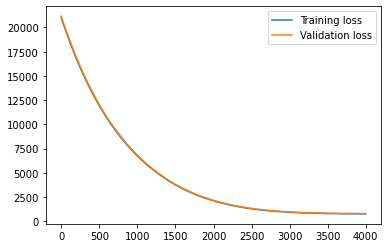

In [29]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label="Training loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()

## Making predictions using the RNN

In [ ]:
hidden = np.zeros(rnn.hidden_units)
cell_values = np.zeros(rnn.hidden_units)

# Check out first state
input_state = np.concatenate([states[0][0], actions[0][0]])

# Construct rnn input
rnn_input = [np.array([[input_state]]),np.array([hidden]),np.array([cell_values])]

# Predict next state
mdn, h, c = rnn.forward.predict(rnn_input)

In [33]:
# Save the model
rnn.forward.save('rnn_predictor_9_actions.hdf5')